# For processing UV-Vis spectroelectrochemistry data
### Rajiv Giridharagopal, rgiri@uw.edu

You can run this notebook by hitting **shift-click** on each cell (including this one!)

You will need to set the data_path below in cell [47] where it says "COPY_PATH_TO_FOLDER_HERE"  
> r'C:\Users\Raj\OneDrive\Documents\Word\uvvis'  

When you copy-paste, ONLY overwrite the part within quotes. Leave the r' ' intact  

In [1]:
import uvvis
import cv
from matplotlib import pyplot as plt
import numpy as np
import scipy as sps
import pickle
import pandas as pd

plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (16, 8)

### Set up Data paths and global processing variables

In [2]:
# 1) Set up the data path
# e.g. r'C:\Users\Raj\OneDrive\Documents\Word\uvvis'
data_path = r'COPY_PATH_TO_FOLDER_HERE'

# don't edit this
if data_path == 'COPY_PATH_TO_FOLDER_HERE':
    from oect_load import file_open
    data_path = file_open(caption='Select folder to load from')
    print('Loading from', data_path)
    # For the same of this demo notebook, I'll pull up some old data.
    # Comment out this line when you want to actually run this! Just type a # in front of the line
#data_path = r'C:\Users\Raj\OneDrive\UW Work\Data\DPP-DTT\_uvVis\20190306 - DPPDTT 28 20 mgmL\01 - 28 20 mg unwashed KPF6'

# 2) Select the wavelength for extracting kinetics, and the potential for plotting time-dependent spectra
wavelength = 500
potential = 0.7

# 3) For saving the figures, add a small string to the filename. e.g. "20190825". By default it's blank
filenamestring = ''

# 4) Save path. By default this will just be in the data path
path = data_path

In [3]:
# This block reads all the text files and saves them as a list of file paths for Python to read
#   Steps = the voltage steps. Not actually needed but it contains the current
#   Specs = spectra
#   Volts = potentials extracted from the steps files

steps, specs, volts, dedopesteps, dedopespecs = uvvis.read_files(data_path)

## 1. Process Data!

#### Here's what this block does:

First, we load the data as a uvvis object
> data = uvvis.uvvis(steps, specs, volts)

1) Now, we process the data by reading in all the spectra at each voltage.  
This step takes all the spectra and saves the time=0 s (initial) spectra at each voltage as a big matrix
It then extracts absorbance vs voltage at a specific wavelength. The command below is at 500 nm
> data.spec_echem_voltage(wavelength=500)

2) Then, we create a giant dictionary that contains a huge matrix of each time-dependent spectra  
> data.time_dep_spectra()

To access the 0.7 V, for example, you'd run this then type 
> data.spectra_vs_time[0.7]

3) Finally, we extract a single time-dependent kinetics trace. Edit the potential and wavelength (wl) based on your data. The command below plots the kinetics for the 0.7 V case and wavelength=500 nm:
> data.single_wl_time(wavelength = 500, potential = 0.7)

4) As an option, we can extract the current from the 'steps' files. This is not that critical
> data.current_vs_time()

Lastly, this saves the data as 2 ".PKL" (pickle) files, dopingdata.pkl and dedopingdata.pkl. It's ~120 MB as opposed to 2 GB, and contains all the data!

In [4]:
# Load Data

# Did you already load any data? If so, this avoids reprocessing. You can manually override this by changing to True
overwrite = False

if not overwrite:
    try:
        with open(path + r'\dopingdata.pkl', 'rb') as input:
            data = pickle.load(input)
        print('Loaded existing doping data')
        with open(path + r'\dedopingdata.pkl', 'rb') as input:
            dedata = pickle.load(input)
        print('Loaded existing dedoping data')
        print('If you REALLY want to re-process all the data, change overwrite to True. You should not need to do this.')
    except:
        overwrite = True

if overwrite:
    ####### LOAD DATA ######
    data = uvvis.uv_vis(steps, specs, volts)

    # Actual processing of data. This takes a long time!!
    print('Processing data...hold on!')
    
    # Time-dependent spectra
    print('Generating spectra vs time')
    try:
        data.time_dep_spectra(specfiles=specs) 
    except:
        print('time-dependent spectra failed')
    
    # Single wavelength kinetics
    print('Extracting single wavelength kinetics')
    try:
        data.single_wl_time(wavelength=wavelength, potential=potential)
    except:
        print('single wavelength spectra failed')
        
    # Integrated current
    print('Current extraction')
    try:
        data.current_vs_time(stepfiles=steps)
        print('Total integrated charge at each voltage')
        print(data.charge)
    except:
        data.charge=[0]
        print('current extraction')
        
    # Time slice spectra
    print('Single DataFrame of time slice t=0')
    try:
        data.spec_echem_voltage(time=0)
    except:
        print('time-slice spectra failed')
    
    with open(path + '\dopingdata.pkl', 'wb') as output:
    
        pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)

    #### DEDOPING DATA ######
        
    if any(dedopespecs):
        dedata = uvvis.uv_vis(dedopesteps, dedopespecs, volts)
        print('### Dedoping Data ###' )
        
        print('Processing data...hold on!')
        print('Generating spectra vs time')
        
        
        # Time-dependent spectra
        print('Generating spectra vs time')
        try:
            dedata.time_dep_spectra(specfiles=dedopespecs) 
        except:
            print('time-dependent spectra failed')

        # Single wavelength kinetics
        print('Extracting single wavelength kinetics')
        try:
            dedata.single_wl_time(wavelength=wavelength, potential=potential)
        except:
            print('single wavelength spectra failed')
        # Integrated current
        print('Current extraction')
        try:
            dedata.current_vs_time(stepfiles=steps)
            print('Total integrated charge at each voltage')
            print(data.charge)
        except:
            dedata.charge=[0]
            print('current extraction')
        
        # Time slice spectra
        print('Single DataFrame of time slice t=0')
        try:
            dedata.spec_echem_voltage(time=0)
        except:
            print('time-slice spectra failed')
    
        with open(path + '\dedopingdata.pkl', 'wb') as output:
    
            pickle.dump(dedata, output, pickle.HIGHEST_PROTOCOL)
    else:
        dedata = [] # flag for later

Processing data...hold on!
Generating spectra vs time
Extracting single wavelength kinetics
Current extraction
Total integrated charge at each voltage
Single DataFrame of time slice t=0
### Dedoping Data ###
Processing data...hold on!
Generating spectra vs time
Extracting single wavelength kinetics
Current extraction
Total integrated charge at each voltage
Single DataFrame of time slice t=0


In [10]:
# Saves as an HDF5, more flexible than a Pickle
import h5py

with h5py.File(data_path+'\dopingdata.h5', 'w') as f:
    dset = f.create_dataset('potentials', (len(data.potentials),))
    dset[:] = data.potentials[:]
    #dset = f.create_dataset('charge', (len(data.charge.values[0]),))
    #dset[:] = data.charge.values[0][:]
f.close()

for p in data.spectra_vs_time:
    data.spectra_vs_time[p].to_hdf(data_path+'\dopingdata.h5', key='x'+str(p), mode='a')
    
#data.current.to_hdf(data_path+'\dopingdata.h5', key ='current', mode='a')

with h5py.File(data_path+'\dedopingdata.h5', 'w') as f:
    dset = f.create_dataset('potentials', (len(dedata.potentials),))
    dset[:] = dedata.potentials[:]
    #dset = f.create_dataset('charge', (len(dedata.charge.values[0]),))
    #dset[:] = dedata.charge.values[0][:]
f.close()
    
for p in dedata.spectra_vs_time:
    data.spectra_vs_time[p].to_hdf(data_path+'\dedopingdata.h5', key='x'+str(p), mode='a')
#dedata.current.to_hdf(data_path+'\dedopingdata.h5', key ='current', mode='a')

C:\Users\cgbis\Anaconda3\lib\site-packages\tables\path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'x0.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
C:\Users\cgbis\Anaconda3\lib\site-packages\tables\path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'x0.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
C:\Users\cgbis\Anaconda3\lib\site-packages\tables\path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'x0.5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
C:\Users\cgbi

## 2. Cool Plots!

### First, simple spectra vs voltage

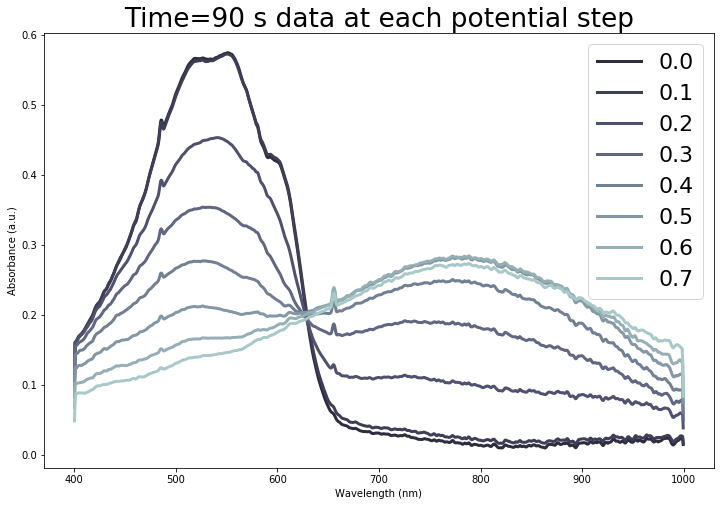

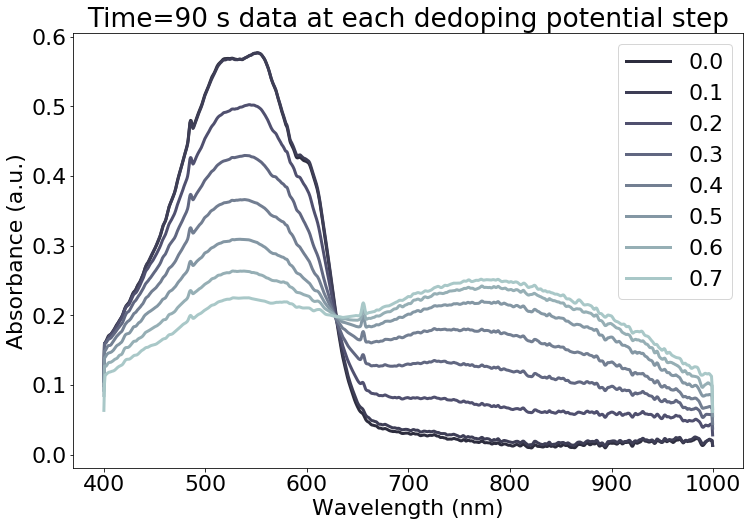

In [5]:
fig, ax = plt.subplots(nrows=1, figsize=(12,8), facecolor='white')
plt.rcParams.update({'font.size': 22})

# This block just generates a cool colormap
# In the last line, you can replace "bone" with any colormap name from here: 
#     https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
cm = np.linspace(0.2,0.75,len(data.spectra_sm.columns))
for i,cl in zip(data.spectra_sm, cm):
    ax.plot(data.spectra_sm[i], linewidth=3,
           color=plt.cm.bone(cl))  

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (a.u.)')
ax.legend(labels = data.potentials)
ax.set_title('Time=90 s data at each potential step')

plt.savefig(path + r'\\' + 'Doping Spectra, t=0 s'+filenamestring+'.jpg')

if dedata:
    fig, ax = plt.subplots(nrows=1, figsize=(12,8), facecolor='white')
    plt.rcParams.update({'font.size': 22})

    # This block just generates a cool colormap
    # In the last line, you can replace "bone" with any colormap name from here: 
    #     https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    cm = np.linspace(0.2,0.75,len(data.spectra_sm.columns))
    for i,cl in zip(dedata.spectra_sm, cm):
        ax.plot(dedata.spectra_sm[i], linewidth=3,
               color=plt.cm.bone(cl))  

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Absorbance (a.u.)')
    ax.legend(labels = dedata.potentials)
    ax.set_title('Time=90 s data at each dedoping potential step')

    plt.savefig(path + r'\\' + 'Dedoping Spectra, t=0 s'+filenamestring+'.jpg')


### Now, let's plot spectra vs time for a particular voltage.
##### Change this line
> potential = 0.7 
##### to whatever voltage you want to plot the kinetics of

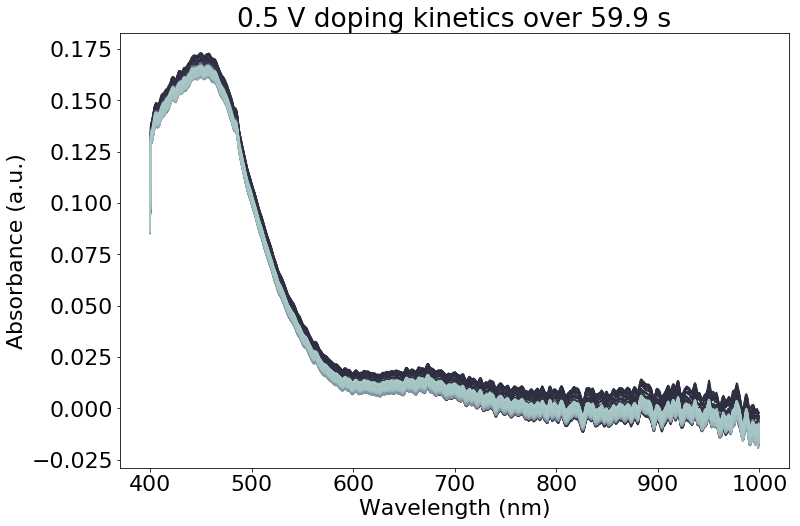

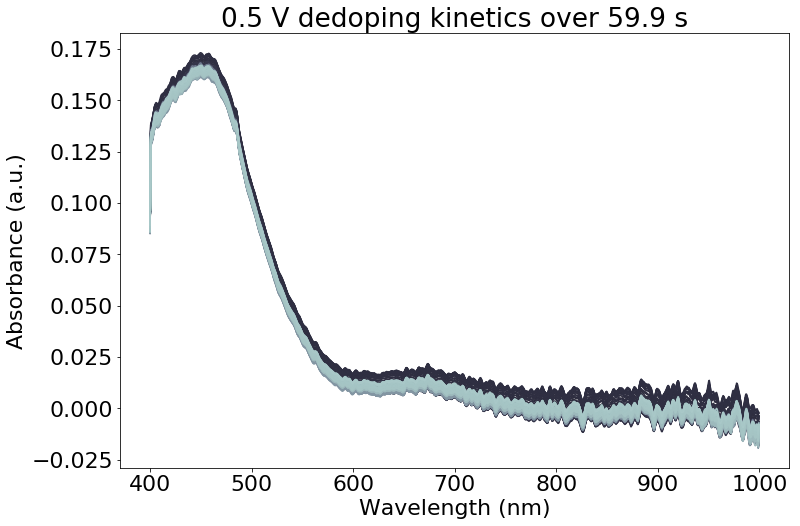

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')

potential = 0.5 # Change this to whatever voltage you want to plot

endtime = data.spectra_vs_time[potential].columns[-1]
cm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potential].columns))
for i,cl in zip(data.spectra_vs_time[potential], cm):
    ax.plot(data.spectra_vs_time[potential][i], color=plt.cm.bone(cl*1))
    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (a.u.)')
ax.set_title(str(potential) +' V doping kinetics over ' + str(endtime) + ' s')

plt.savefig(path + r'\\' + 'Doping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg')

if dedata:
    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')

    #potential = 0.7 # Change this to whatever voltage you want to plot

    endtime = dedata.spectra_vs_time[potential].columns[-1]
    cm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potential].columns))
    for i,cl in zip(dedata.spectra_vs_time[potential], cm):
        ax.plot(dedata.spectra_vs_time[potential][i], color=plt.cm.bone(cl*1))

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Absorbance (a.u.)')
    ax.set_title(str(potential) +' V dedoping kinetics over ' + str(endtime) + ' s')

    plt.savefig(path + r'\\' + 'Dedoping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg')


### Plot the kinetics at a particular wavelength and voltage

##### Change these lines
> potential = 0.7  
> wavelength = 800  
##### to whatever voltage and wavelength you want

In [6]:
def exp_fit(t, y, A, tau):
    return y + A * np.exp(-t / tau)

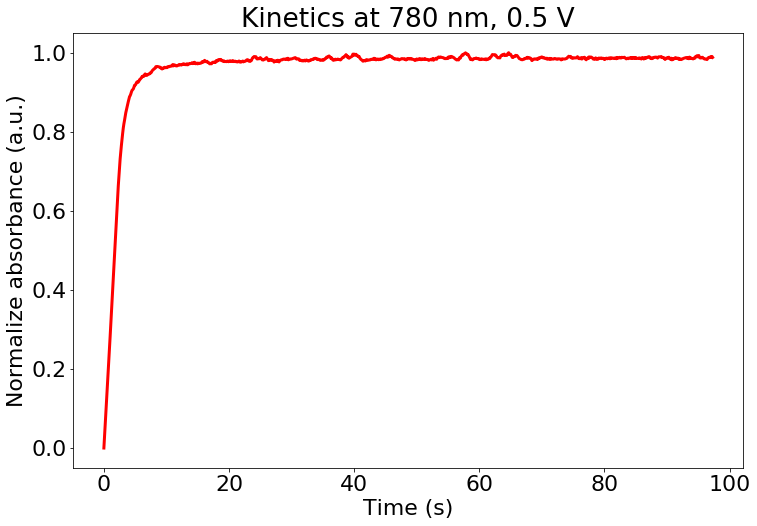

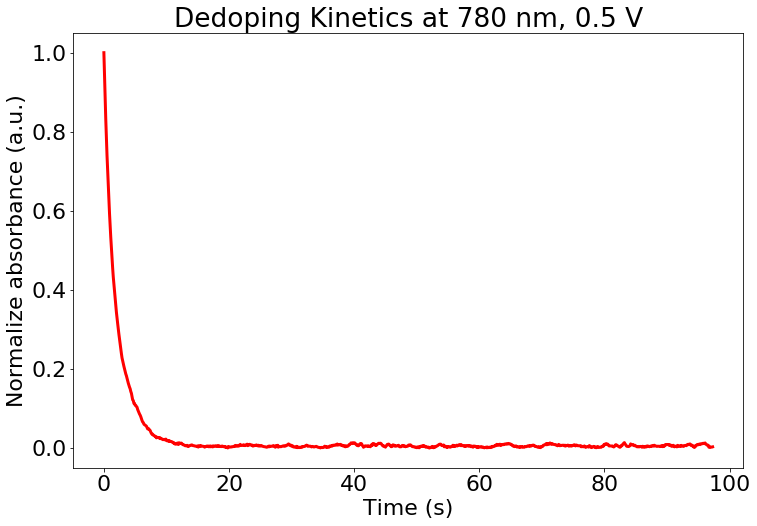

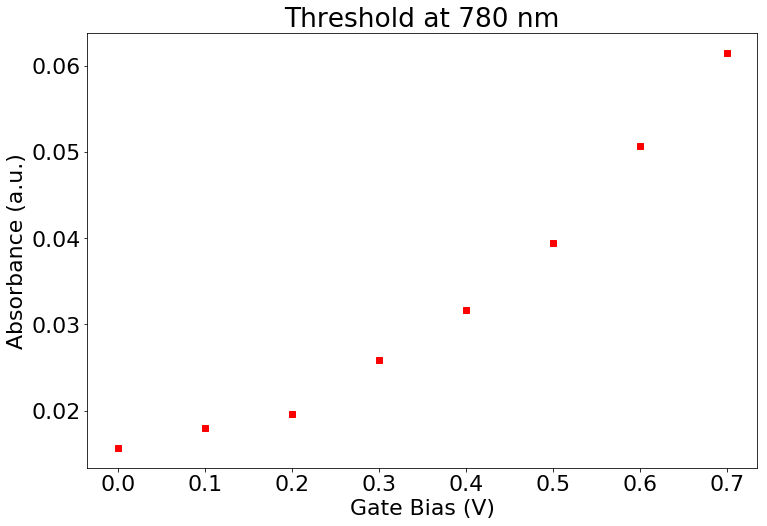

In [7]:
# Changes these two lines to whatever potential and wavelength you want
potential = 0.5
wavelength = 780

data.single_wl_time(potential=potential, wavelength = wavelength)
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
uvvis.plot_time(data, ax=ax, **{'color':'r', 'linewidth': 3})
ax.set_title('Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V')

plt.savefig(path + r'\\' + 'Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V'
            +filenamestring+'.jpg')

if dedata:
    dedata.single_wl_time(potential=potential, wavelength = wavelength)
    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
    uvvis.plot_time(dedata, ax=ax, **{'color':'r', 'linewidth': 3})
    ax.set_title('Dedoping Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V')

    plt.savefig(path + r'\\' + 'Dedope Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V'
                +filenamestring+'.jpg')
    
fig, ax1 = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
uvvis.plot_voltage(data, ax=ax1, time=0, **{'color':'r', 'linewidth': 0, 'marker':'s'})
ax1.set_title('Threshold at ' + str(wavelength) + ' nm')

plt.savefig(path + r'\\' + 'Threshold at ' + str(wavelength) + ' nm'
            +filenamestring+'.jpg')

### Plot the kinetics over a band of wavelengths at a given voltage and/or charge integrated

KeyError: 0.8

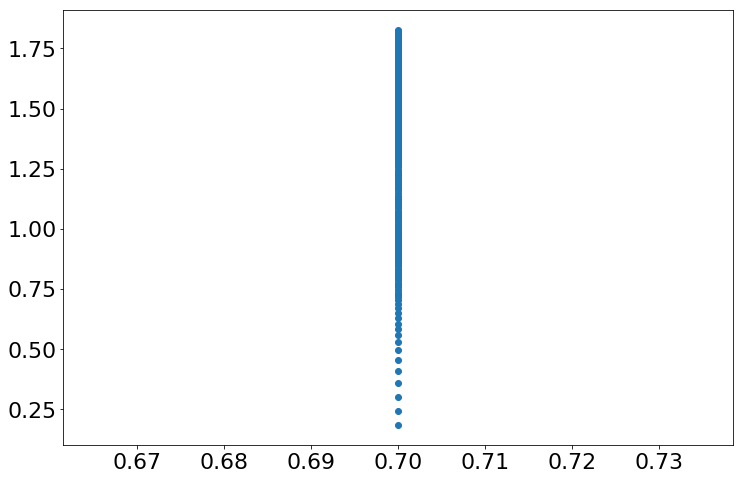

In [8]:
#Choose wavelengths to plot about
wl_start = 500
wl_stop = 700
potentials = [0.7, 0.8]
times = {}

fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    ax.plot(p * np.ones(len(data.fits)), data.fits, 'o')
    
ax.set_ylabel('Time Constant (s)')
ax.set_xlabel('Potential (V)')
ax.set_title('Doping Potential-Dependent Rates from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')
plt.savefig(path + r'\\' + 'Doping Potential-Dependent Kinetics from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'
            +filenamestring+'.jpg')
            
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    ax.plot(p * np.ones(len(data.fits)), np.array(data.fits)**-1, 'o')
    
ax.set_ylabel('Rate Constant (Hz)')
ax.set_xlabel('Potential (V)')
ax.set_title('Doping Potential-Dependent Rates from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')
plt.savefig(path + r'\\' + 'Doping Potential-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'
            +filenamestring+'.jpg')

In [ ]:
#Choose wavelengths to plot about
wl_start = 750
wl_stop = 850
potentials = [0.7, 0.8, 0.9, 1]

times = {}

fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    ax.plot(data.charge[p].values * np.ones(len(data.fits)), data.fits, 'o')
    
ax.set_ylabel('Time Constant (s)')
ax.set_xlabel('Charge injected (mC)')
ax.set_title('Charge-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')
plt.savefig(path + r'\\' + 'Doping Charge-Dependent Kinetics from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'
            +filenamestring+'.jpg')
            
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    ax.plot(data.charge[p].values * np.ones(len(data.fits)), np.array(data.fits)**-1, 'o')
    
ax.set_ylabel('Rate Constant (Hz)')
ax.set_xlabel('Charge injected (mC)')
ax.set_title('Charge-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')
plt.savefig(path + r'\\' + 'Doping Charge-Dependent Rates from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'
            +filenamestring+'.jpg')

### Plot the kinetics as a rad-looking spectrogram

#### These data are not actually any different from the above kinetics data

In [ ]:
# Change potential to whatever voltage you want
# change cmap only if you know what that means
potential = 0.7
kwargs = {}
kwargs['cmap'] = 'icefire'

# Sets up two dataframes for plotting
import pandas as pd
import seaborn as sns
wl = np.round(data.spectra_vs_time[potential].index.values, 2)
df = pd.DataFrame.copy(data.spectra_vs_time[potential])
df = df.set_index(wl)
dfv = pd.DataFrame.copy(data.spectra_sm)
dfv = dfv.set_index(wl)

# spectra vs time
fig, ax0 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
sns.heatmap(df,ax=ax0, **kwargs)    
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Wavelength (nm)')
plt.savefig(path + r'\\' + 'Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg')

# spectra vs voltage
fig, ax1 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
sns.heatmap(dfv,ax=ax1, **kwargs)    
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Wavelength (nm)')

plt.savefig(path + r'\\' + 'Spectrogram at t = 0 s'
            +filenamestring+'.jpg')

In [ ]:
if dedata:
        # Change potential to whatever voltage you want
    # change cmap only if you know what that means
    #potential = 0.7
    kwargs = {}
    kwargs['cmap'] = 'icefire'

    # Sets up two dataframes for plotting
    import pandas as pd
    import seaborn as sns
    wl = np.round(dedata.spectra_vs_time[potential].index.values, 2)
    df = pd.DataFrame.copy(dedata.spectra_vs_time[potential])
    df = df.set_index(wl)
    dfv = pd.DataFrame.copy(dedata.spectra_sm)
    dfv = dfv.set_index(wl)

    # spectra vs time
    fig, ax0 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
    sns.heatmap(df,ax=ax0, **kwargs)    
    ax0.set_xlabel('Time (s)')
    ax0.set_ylabel('Wavelength (nm)')
    plt.savefig(path + r'\\' + 'Dedoping Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg')

    # spectra vs voltage
    fig, ax1 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
    sns.heatmap(dfv,ax=ax1, **kwargs)    
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Wavelength (nm)')

    plt.savefig(path + r'\\' + 'Dedoping Spectrogram at t = 0 s'
                +filenamestring+'.jpg')

## 3. A brief tour through what this all contains for your reference

## (This part is not necessary to run)

In [ ]:
# data.spectra -- the data as one large dataframe vs voltage
data.spectra

In [ ]:
# All the spectra vs time
data.spectra_vs_time

In [ ]:
data.time_spectra_norm # normalized time-dependent spectra

In [ ]:
data.time_spectra # un-normalized time-dependent spectra